In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import sleep
import os

from numpy.fft import rfft, fftfreq, irfft
from scipy import signal
from scipy.signal import savgol_filter, lfilter
from statistics import mean

# There is an example of running the entire process at the bottom of this notebook

In [30]:
##function for creating separate arrays for each column in data file 
def read_data(data_file):
    
    f = open(os.getcwd() + "/data/"+ data_file, 'r')
    print("metadata: {}".format(f.readline()))
    
    data = pd.read_csv(f)
    cols = data.columns.to_numpy()
    time = data[cols[0]].to_numpy() # time
    high = data[cols[1]].to_numpy()  # high pt
    lox_tank = data[cols[2]].to_numpy() # lox tank
    propane_tank = data[cols[3]].to_numpy()  # propane tank
    lox_injector = data[cols[4]].to_numpy()  # lox injector
    propane_injector = data[cols[5]].to_numpy()  # propane injector
    return data, time, high, lox_tank, propane_tank, lox_injector, propane_injector

In [3]:
def display_pressure(time, data, peaks):
    plt.figure(figsize=(20,10))
    plt.ylabel("Pressure (psi)")
    xticks = np.arange(time[0], time[-1], (time[-1] - time[0]) / 10 )
    xticks = [int(xtick) for xtick in xticks]
    plt.plot(time, data)
    plt.xticks(xticks)
    plt.xlabel("time (s)")
    
    for i in peaks:
        for t in i:
            plt.axvline(t, c='k', lw='1')
    plt.show()
    

In [82]:
def display_all_pressure(time, high, lox_tank, prop_tank, lox_inj, prop_inj, start_time = 0, end_time = -1, show_high=False):
    plt.figure(figsize=(20,10))
    indices = np.arange(len(time))
    start_index, _ = find_closest_element(time, start_time)
    end_index, _ = find_closest_element(time, end_time) if end_time != -1 else -1
    #print("start: {}, end: {}".format(time[start_index], time[end_index]))
    plt.xlabel("time (s)")
    plt.ylabel("PSI")
    plt.plot(time[start_index:end_index], lox_tank[start_index:end_index], label='LOX tank')
    plt.plot(time[start_index:end_index], propane_tank[start_index:end_index], label='prop tank')
    plt.plot(time[start_index:end_index], lox_inj[start_index:end_index], label='lox inj')
    plt.plot(time[start_index:end_index], prop_inj[start_index:end_index], label='prop inj')
    if(show_high):
        plt.plot(time[start_index:end_index], high[start_index:end_index], label='Pressurant Tank')
    plt.legend()
    plt.show()
        

In [51]:
def filter_data(time, signal):
    W = fftfreq(signal.size, d=time[1]-time[0])#omegas
    print(np.shape(W))
    f_signal = rfft(signal)
    print(np.shape(f_signal))

    # If our original signal time was in seconds, this is now in Hz    
    cut_f_signal = f_signal.copy()
    cut_f_signal[(W>50)] = 0

    return irfft(cut_f_signal)

In [5]:
def find_closest_element(collection, val):
    index = min(range(len(collection)), key=lambda i: abs(collection[i]-val))
    return index, collection[index]

In [ ]:
pressure_df, time, high, lox_tank, propane_tank, lox_injector, propane_injector = read_data("coldflow3.1_20-10-24__17_15.csv")

smoothed_high = savgol_filter(high, 31, 2)
smoothed_lox_tank = savgol_filter(lox_tank, 31, 2)
smoothed_propane_tank = savgol_filter(propane_tank, 51, 2)
smoothed_lox_injector = savgol_filter(lox_injector, 41, 2)
smoothed_propane_injector = savgol_filter(propane_injector, 41, 2)

5440


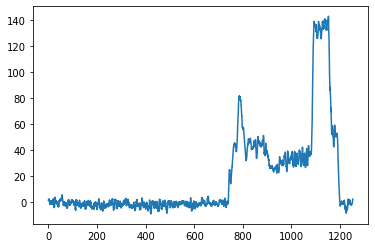

In [56]:
print(len(time))
lox_test = savgol_filter(lox_tank, 41, 2)
plt.plot(time, lox_test)

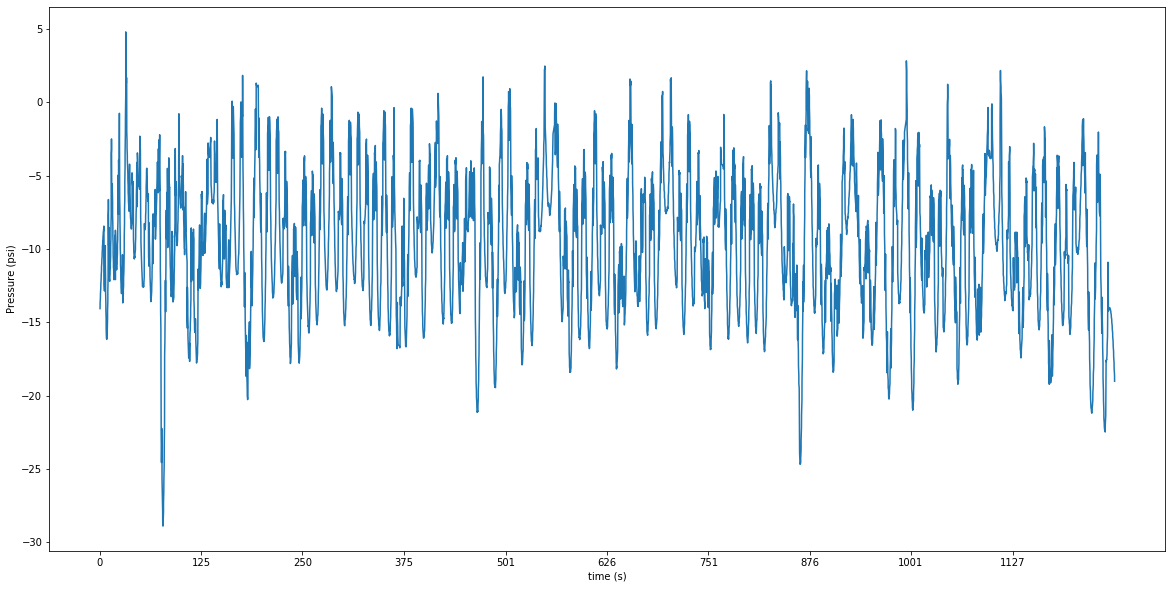

In [80]:
display_pressure(time, smoothed_propane_tank, [])

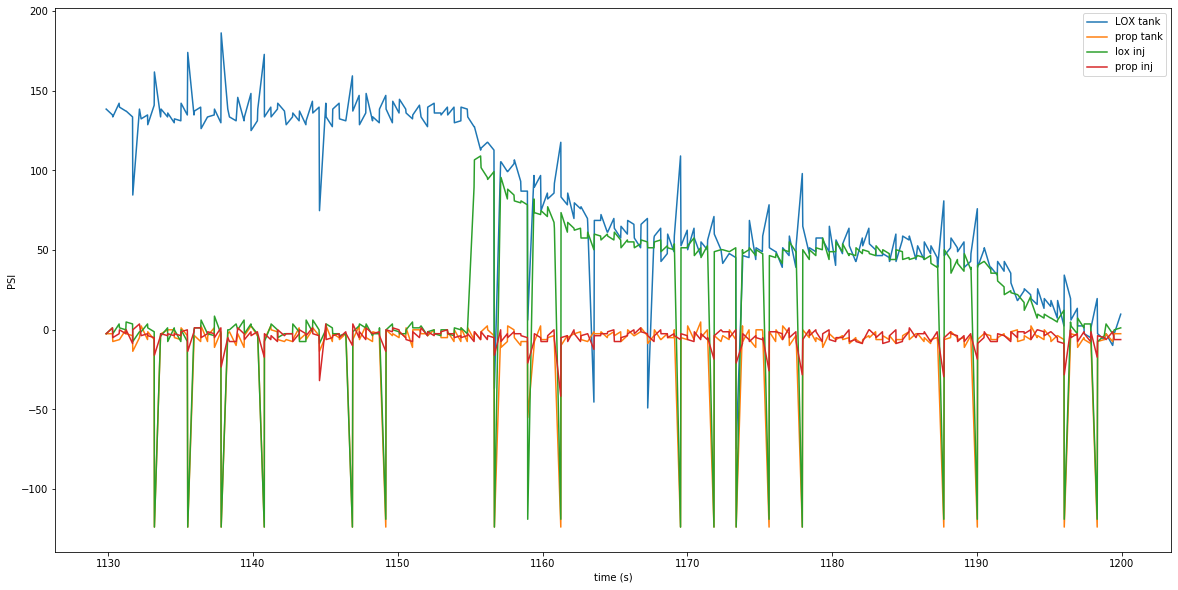

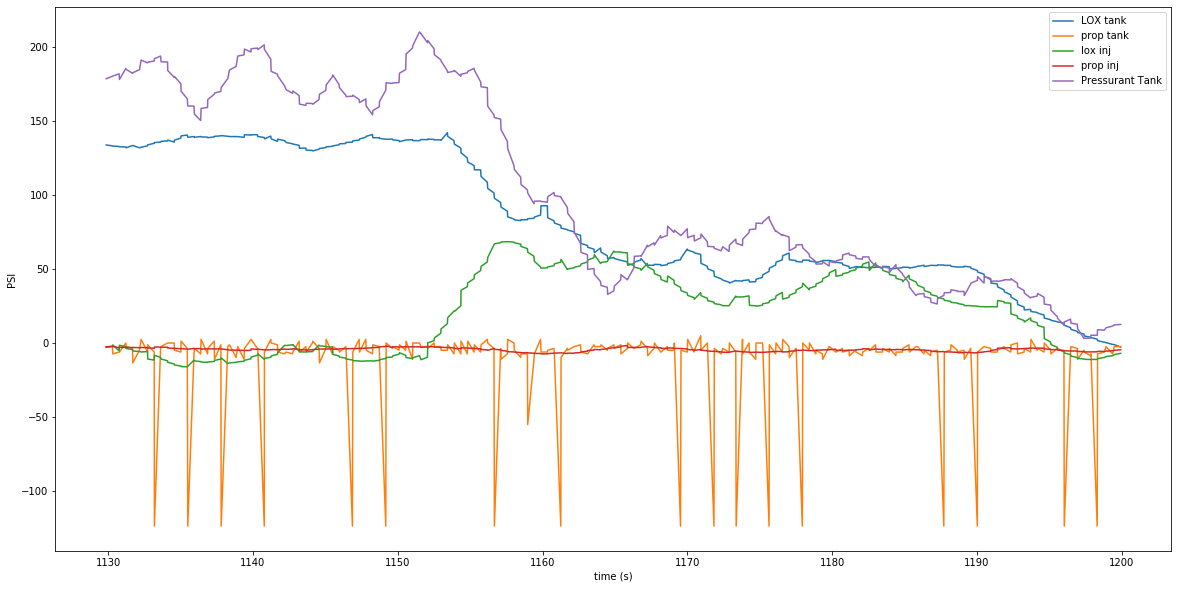

In [98]:
start_t = 1130
end_t = 1200
display_all_pressure(time, high, lox_tank, propane_tank, lox_injector, propane_injector, start_t, end_t)
display_all_pressure(time, smoothed_high, smoothed_lox_tank, smoothed_propane_tank, smoothed_lox_injector, smoothed_propane_injector, start_t, end_t, show_high=True)

In [68]:
##current version of detect function
##added third "zoom-in" without dary data 
def detect_peaks(data):
    time = data[0]
    pdata = data[1]
    
    print("Amount of Data Points:", len(pdata))
    n = 100  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    filter_data2 = lfilter(b,a,pdata)
    dary = np.array([*map(float, pdata)])
    dary -=np.average(dary)
    step = np.hstack((np.ones(len(dary)), -1*np.ones(len(dary))))

    dary_step = np.convolve(dary, step, mode='valid')
    peaksall=[]
    peaks = signal.find_peaks(dary_step, width=20)[0]
    print("trying it out:", peaks)
    if len(peaks)>0:
        for p in peaks:
            
            peaksall.append(np.array([p]))
    print("Positive Peaks:", len(peaks))
    peaks2 = signal.find_peaks(-dary_step, width=20)[0]
    print("Negative Peaks:", len(peaks2))
    if len(peaks2)>0:
        for p in peaks2:
            
            peaksall.append(np.array([p]))
    print("Total Peaks detected:", len(peaksall))
    print(peaksall)
    plt.figure()

    plt.plot(dary)

    plt.plot(dary_step/10)

    for ii in range(len(peaks)):
        plt.plot((peaks[ii], peaks[ii]), (-1500, 1500), 'r')

    plt.show()
    ##start of second round
    #creating new data set with first and last peak as lower, upper bounds
    if len(peaksall)>=2:
        data2 = pdata[int(peaksall[0][0]):int(peaksall[-1][-1])]
    else:
        data2 = pdata[0:int(peaksall[-1])]
    ##
    n = 5  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    filter_data = lfilter(b,a,data2)
    ##
    dary2 = np.array([*map(float, data2)])
    
    dary2 -=np.average(dary2)
    step2 = np.hstack((np.ones(len(dary2)), -1*np.ones(len(dary2))))

    dary_step2 = np.convolve(dary2, step2, mode='valid')

    # Get the peaks of the convolution
    #negative peaks
    peaks3 = signal.find_peaks(-dary_step2, width=20)[0]
    #positive peaks
    peaks4 = signal.find_peaks(dary_step2, width=20)[0]
    #adjusting for frame shift
    if len(peaksall)>=2:
        if len(peaks3)>0:
            for p in range(len(peaks3)):
                peaksall.append(np.array([peaks3[p]+peaks[0]+1]))
            #peaksall.append(peaks3+peaks+1)
        print("Negative Peaks Detected:", len(peaks3), "at", peaks3)
        if len(peaks4)>0:
            for p in range(len(peaks4)):
                peaksall.append(np.array([peaks4[p]+peaks[0]+1]))
            #peaksall.append(peaks4+peaks+1)
        print("Positive Peaks Detected:", len(peaks4), "at", peaks4)
        print(peaksall)
    else:
        if len(peaks3)>0:
            for p in range(len(peaks3)):
                peaksall.append(np.array([peaks3[p]]))
        print("Negative Peaks Detected:", len(peaks3),"at",peaks3)
        if len(peaks4)>0:
            for p in peaks4:
                
                peaksall.append(np.array([p]))
        print("Positive Peaks Detected:", len(peaks4),"at", peaks4)
        print(peaksall)
    ###make this more robust
    #peaks2 = signal.find_peaks(-dary_step, width=20)[0]
    print(peaks3)

    # plots
    plt.figure()

    plt.plot(dary2)
    #orange:
    plt.plot(dary_step2/10)
    #repeat process on dary data:
    n = 20  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    filter_data3 = lfilter(b,a,dary_step2/10)
    peaks40 = signal.find_peaks(filter_data3, width=20)[0]
    peaks30 = signal.find_peaks(-filter_data3, width=20)[0]
    peaksall2=[]
    plt.plot(filter_data3)
    for ii in range(len(peaks40)):
        plt.plot((peaks40[ii], peaks40[ii]), (-150, 150), 'green')
    ##adding to master graph
    if len(peaksall)>=2:
        if len(peaks30)>0:
            for p in range(len(peaks30)):
                print("testing peaks:",peaks)
                print("testing peaks30:", peaks30)
                peaksall2.append(np.array([peaks30[p]+peaks[0]+1]))
#                 print("testing something:", np.array([peaks30[p]+peaks[p]+1]))
            #peaksall2.append(peaks30+peaks+1)
#         print("Negative Peaks Detected:", len(peaks30), "at", peaks30)
        if len(peaks40)>0:
            for p in range(len(peaks40)):
                peaksall2.append(np.array([peaks40[p]+peaks[0]+1]))
            #peaksall2.append(peaks40+peaks+1)
#         print("Positive Peaks Detected:", len(peaks40), "at", peaks40)
#         print("This is peaksall2:",peaksall2)
    else:
        if len(peaks30)>0:
            for p in peaks30:
                peaksall2.append(np.array([p]))
            #peaksall2.append(peaks30)
        print("Negative Peaks Detected:", len(peaks30),"at",peaks30)
        if len(peaks40)>0:
            for p in peaks40:
                peaksall.append(np.array([p]))
            #peaksall2.append(peaks40)
        print("Positive Peaks Detected:", len(peaks40),"at", peaks40)
        print(peaksall2)
    ## appending 2nd round of lines to first
    
    peaksall = peaksall + peaksall2
    print("This is peaksall:", peaksall)
    peaksall.sort()
    
        
    for ii in range(len(peaks3)):
        plt.plot((peaks3[ii], peaks3[ii]), (-150, 150), 'r')

    plt.show()
    
    ##end of second round
    print("end of second round")
    
    ##start of third round
    #creating new data set with first and last peak as lower, upper bounds
    if len(peaksall)>=2:
        data2 = pdata[int(peaksall[0][0]):int(peaksall[2][-1])]
    else:
        data2 = pdata[0:int(peaksall[-1])]
    ##
    n = 5  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    filter_data4 = lfilter(b,a,data2)
    ##
    dary2 = np.array([*map(float, filter_data4)])
    
    dary2 -=np.average(dary2)
    step2 = np.hstack((np.ones(len(dary2)), -1*np.ones(len(dary2))))

    dary_step2 = np.convolve(dary2, step2, mode='valid')

    # Get the peaks of the convolution
    #negative peaks
    peaks3 = signal.find_peaks(-dary_step2, width=20)[0]
    #positive peaks
    peaks4 = signal.find_peaks(dary_step2, width=20)[0]
    #adjusting for frame shift
    if len(peaksall)>=2:
        if len(peaks3)>0:
            for p in range(len(peaks3)):
                peaksall.append(np.array([peaks3[p]+peaks[0]+1]))
            #peaksall.append(peaks3+peaks+1)
        print("Negative Peaks Detected:", len(peaks3), "at", peaks3)
        if len(peaks4)>0:
            for p in range(len(peaks4)):
                peaksall.append(np.array([peaks4[p]+peaks[0]+1]))
            #peaksall.append(peaks4+peaks+1)
        print("Positive Peaks Detected:", len(peaks4), "at", peaks4)
        print(peaksall)
    else:
        if len(peaks3)>0:
            for p in range(len(peaks3)):
                peaksall.append(np.array([peaks3[p]]))
        print("Negative Peaks Detected:", len(peaks3),"at",peaks3)
        if len(peaks4)>0:
            for p in peaks4:
                
                peaksall.append(np.array([p]))
        print("Positive Peaks Detected:", len(peaks4),"at", peaks4)
        print(peaksall)
    ###make this more robust
    #peaks2 = signal.find_peaks(-dary_step, width=20)[0]
    print(peaks3)

    # plots
    plt.figure()

    plt.plot(dary2)
    #orange:
    plt.plot(dary_step2/10)
    
    peaksall.sort()
    
        
    for ii in range(len(peaks3)):
        plt.plot((peaks3[ii], peaks3[ii]), (-150, 150), 'r')

    plt.show()
    
    ##end of third round
    print("end of third round")
    
    peak_times = [time[peak] for peak in peaksall]


    display_pressure(time, pdata, peak_times)
    
    
    return [time,pdata,peak_times]

In [69]:
##function for adding lines
def add_lines(detect_data):
    ##plotting input data
    
    peaksall = detect_data[2]
    data = detect_data[1]
    time = detect_data[0]
    
    display_pressure(time, data, peaksall)
    
    ##adding new lines with user input
    
    user_input3 = input("List of lines to add, by approximate X axis value (can edit later for precision):")
    
    if user_input3:
        new_lines =  list(map(int,user_input3.split(',')))
        
        for i in new_lines:
            peaksall.append(np.array([i]))
 
        display_pressure(time, data ,peaksall)

        plt.show()
    
    
    return [time, data, peaksall]
    

In [70]:
##function for editing lines
def edit_lines(detect_data):
    ##plotting input data
    ##data[0] = pressure data
    ##data[1] = array of detected peaks
    peaksall = detect_data[2]
    data = detect_data[1]
    time = detect_data[0]
    
    display_pressure(time, data, peaksall)
    
    ###shifting lines with user input
    
    user_input2 = input("Times of lines to edit, separated by comma, e.g. 103, 58, 12: ") 
    
    if user_input2:
        time_list =  list(map(int,user_input2.split(',')))
        index_list = [find_closest_element(time, t)[0] for t in time_list]
        print(index_list)
        
        for i in index_list:

            print("time", "Pressure")
            print(time[i-5], data[i-5])
            print(time[i-4], data[i-4])
            print(time[i-3], data[i-3])
            print(time[i-2], data[i-2])
            print(time[i-1], data[i-1])
            #print("Current Line:")
            print("* ", time[i], data[i])
            print(time[i+1], data[i+1])
            print(time[i+2], data[i+2])
            print(time[i+3], data[i+3])
            print(time[i+4], data[i+4])
            print(time[i+5], data[i+5])

            user_input3 = input("Choose time for new line")

            if user_input3!=None:
                peak_i, _ = find_closest_element(peaksall, time[i])
                del peaksall[peak_i]
                peaksall.insert(peak_i, np.array([float(user_input3)]))


    display_pressure(time, data, peaksall)
    peaksall.sort()
    return [time, data, peaksall]
    

In [71]:
##function for removing lines
def remove_lines(detect_data):
    ##plotting input data
    
    peaksall = detect_data[2] # actual times, not indices.
    
    data = detect_data[1]
    time = detect_data[0]
    display_pressure(time, data, peaksall)
    
    ##taking user input and removing lines
    user_input = input("Times at which to remove lines, separated by comma, e.g. 53, 32, 9: (will find the closest line and remove it) ")
    
    if user_input:
        a_list =  list(map(int,user_input.split(',')))
        print(a_list)
        print(peaksall)

        #removing lines at index indicated by user input, using inserts to maintain list length in process
        for t in a_list:
            i, _ = find_closest_element(peaksall, t)
            del peaksall[i]

        display_pressure(time, data, peaksall)
        
        return [time, data, peaksall]

In [72]:
##function for returning values
def values(detect_data):
    ##plotting input data
    ##data[0] = pressure data
    ##data[1] = array of detected peaks
    peaksall = detect_data[2]
    data = detect_data[1]
    time = detect_data[0]
    
    display_pressure(time, data, peaksall)
    
    ##taking input on data type and returning parameters according to data type
    ##can probably be done with radios in gui
    data_type = input("Data Type (high, propane injector, propane tank, lox injector, or lox tank)")
    
    if "tank" in data_type:
        static_start_index, _ = find_closest_element(time, peaksall[0])
        dynamic_start_index, _ = find_closest_element(time, peaksall[1])
        dynamic_end_index, _ = find_closest_element(time, peaksall[2])
        
        
        static_condition = data[static_start_index:dynamic_start_index]
        static_pressure = mean(static_condition)
        print("Static Pressure:", static_pressure)
        dynamic_condition = data[dynamic_start_index: dynamic_end_index]
        dynamic_pressure = mean(dynamic_condition)
        print("Dynamic Pressure:", dynamic_pressure)
        droop = static_pressure - dynamic_pressure 
        print("Droop:", droop)
        emptying_time = peaksall[2]-peaksall[1]
        print("Emptying Time:", emptying_time)
        dynamic_rate_of_increase = (data[dynamic_end_index]-data[dynamic_start_index])/emptying_time
        print("Dyanmic Rate of Increase:", dynamic_rate_of_increase)
        return static_pressure, dynamic_pressure, droop, emptying_time, dynamic_rate_of_increase
    elif "injector" in data_type:
        
        dynamic_condition = data[int(peaksall[0]):int(peaksall[1])]
        dynamic_pressure = mean(dynamic_condition)
        print("Dynamic Pressure:", dynamic_pressure)
        emptying_time = int(peaksall[1])-int(peaksall[0])
        print("Emptying Time:", emptying_time)
        return dynamic_pressure, emptying_time
        
    
    elif data_type=="high":
        print("high")
    else:
        ##implement a better way to do this
        print("try again")
        values(detect_data)
     

# Example of entire process:

Using function "create_data" with input "waterflow_10-03-20__20_46.csv" to create 6 arrays for 6 columns in data file:

In [169]:
data_file = "waterflow_10-10-20__21_34.csv"
time, high, lox_tank, propane_tank, lox_injector, propane_injector = create_data(data_file)

Slicing propane tank data to extract useful section:

In [ ]:
display_all_pressure(time, smoothed_high, smoothed_lox_tank, smoothed_propane_tank, smoothed_lox_injector, smoothed_propane_injector, start_time = 1050, end_time=2000, show_high=True)

In [86]:
start_time = 600
end_time = 2000

start_index = min(range(len(time)), key=lambda i: abs(time[i]-start_time))
end_index = min(range(len(time)), key=lambda i: abs(time[i]-end_time)) if end_time != -1 else -1
    

processed_tank_data = np.array([time[start_index:end_index], smoothed_lox_tank[start_index:end_index]])

Using function "detectPeaks" with pressure data input to return a list of the form [(inputted data), (array of X-axis values for detected peaks)]. The variable "testdata" in this case can then be passed into any of the subsequent functions for manipulating the peaks/lines.

Amount of Data Points: 2740
trying it out: [ 693  930 1994]
Positive Peaks: 3
Negative Peaks: 3
Total Peaks detected: 6
[array([693]), array([930]), array([1994]), array([907]), array([1287]), array([2513])]


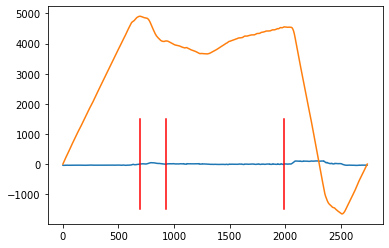

Negative Peaks Detected: 2 at [ 182 1731]
Positive Peaks Detected: 2 at [  73 1369]
[array([693]), array([930]), array([1994]), array([907]), array([1287]), array([2513]), array([876]), array([2425]), array([767]), array([2063])]
[ 182 1731]
testing peaks: [ 693  930 1994]
testing peaks30: [ 188 1720]
testing peaks: [ 693  930 1994]
testing peaks30: [ 188 1720]
This is peaksall: [array([693]), array([930]), array([1994]), array([907]), array([1287]), array([2513]), array([876]), array([2425]), array([767]), array([2063]), array([882]), array([2414]), array([776]), array([2072])]


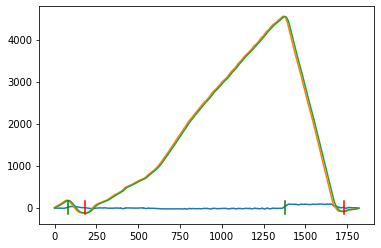

end of second round
Negative Peaks Detected: 0 at []
Positive Peaks Detected: 1 at [65]
[array([693]), array([767]), array([776]), array([876]), array([882]), array([907]), array([930]), array([1287]), array([1994]), array([2063]), array([2072]), array([2414]), array([2425]), array([2513]), array([759])]
[]


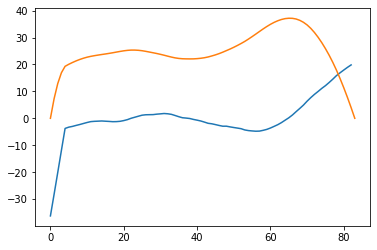

end of third round


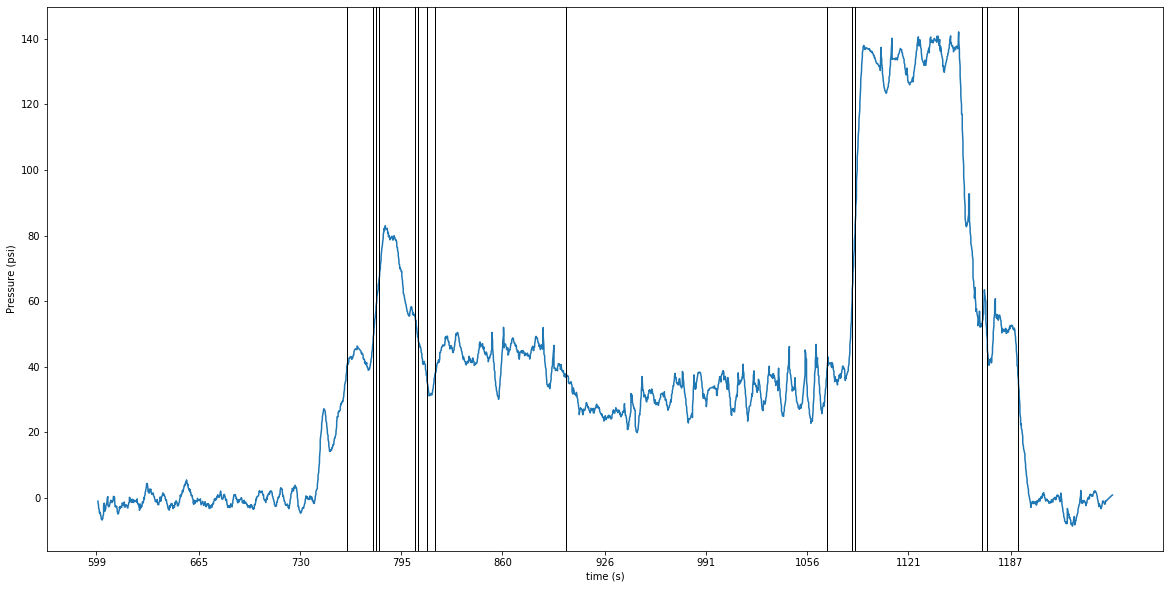

In [87]:
processed_tank_data = detect_peaks(processed_tank_data)

Using function "remove_lines" with testdata input (list with raw data and list of peaks) to remove lines based on user input.  This returns a list of the same format as its input, with changes reflecting user input.  This can be run as many times as you want as long as variables are assigned properly.

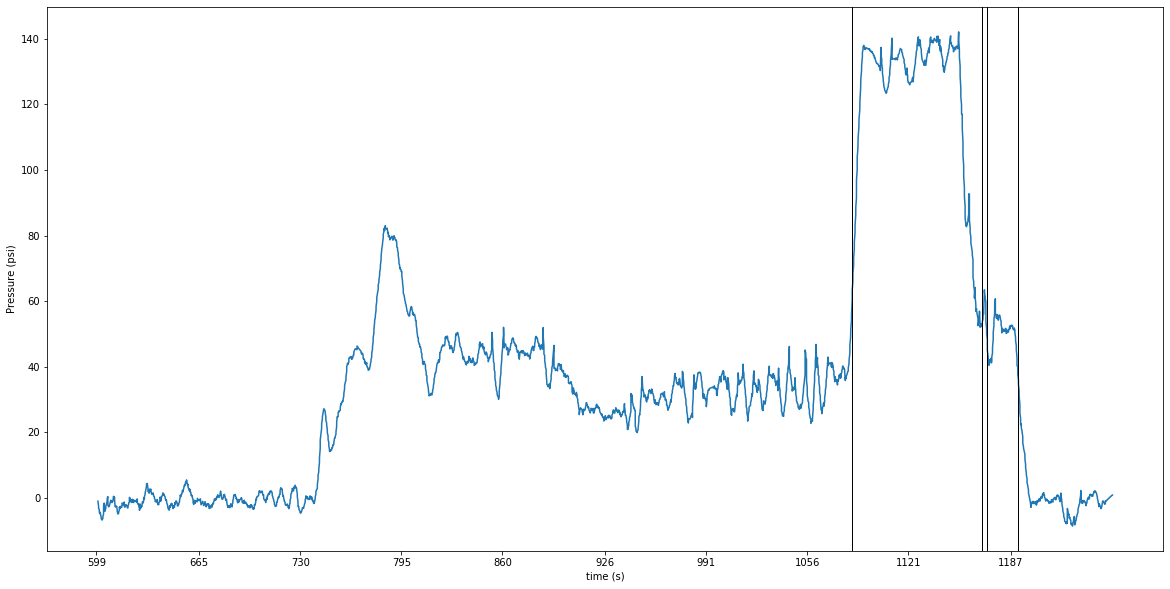

Times at which to remove lines, separated by comma, e.g. 53, 32, 9: (will find the closest line and remove it) 1150, 1160
[1150, 1160]
[array([1084.95243526]), array([1168.6411972]), array([1171.38159323]), array([1191.87558603])]


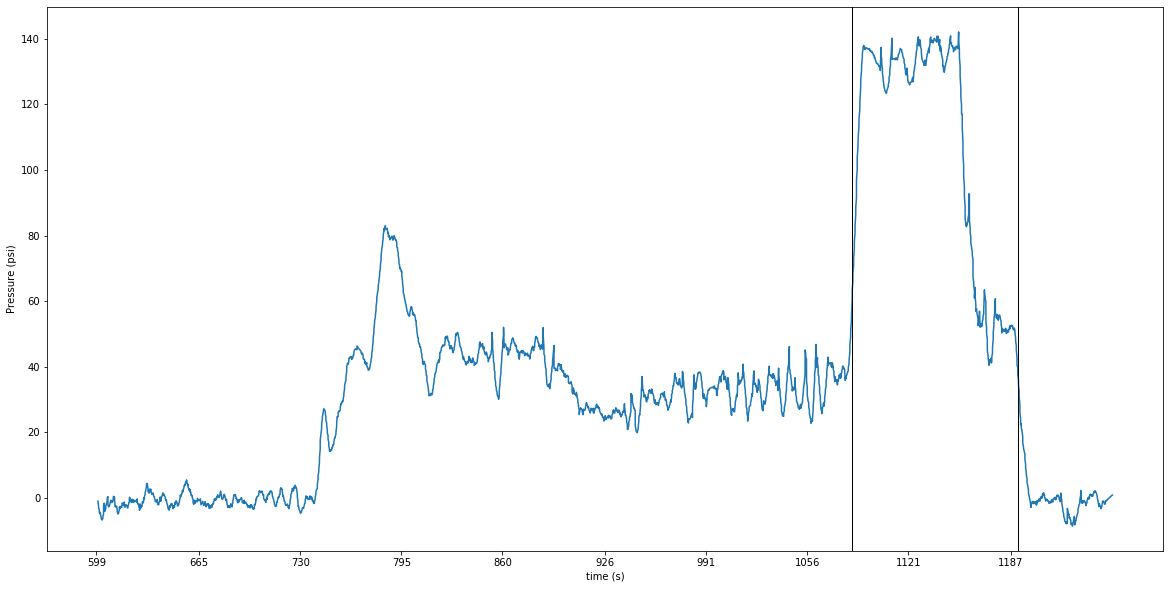

In [90]:
processed_tank_data = remove_lines(processed_tank_data)

Same process as above but with function "add_lines", which adds values to the list of "peaks" according to user input.

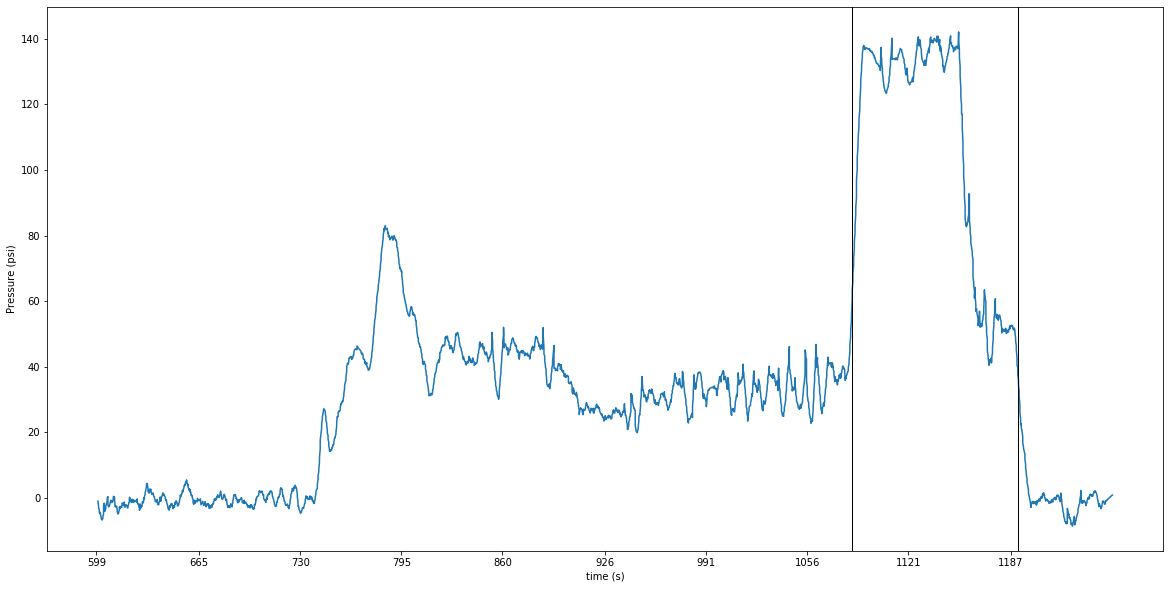

List of lines to add, by approximate X axis value (can edit later for precision):1140


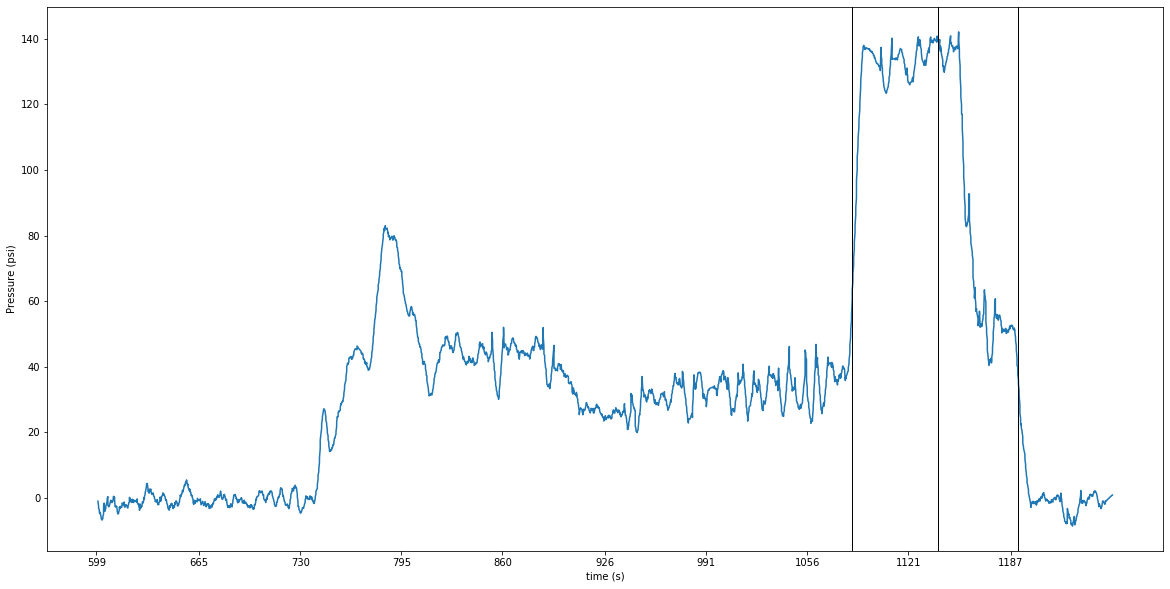

In [91]:
processed_tank_data = add_lines(processed_tank_data)

Same process as above but with function "edit_lines", which moves existing lines to new positions based on user input.

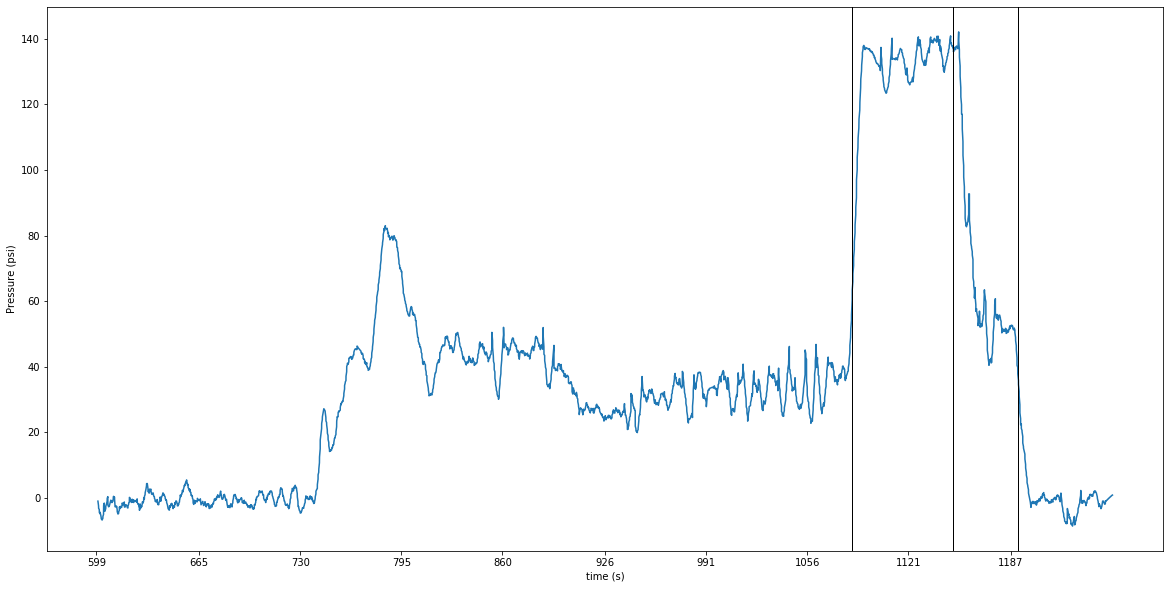

Times of lines to edit, separated by comma, e.g. 103, 58, 12: 1150
[2333]
time Pressure
1148.7363052368166 138.284343556915
1149.1730501651766 137.75662633029523
1149.1938991546629 137.66947922897654
1149.6282291412356 137.83137697338935
1149.654277086258 137.27155291996797
*  1150.0886971950529 136.79515703039792
1150.1176161766052 136.03884911411714
1150.5487442016604 137.15564603556828
1150.5747933387754 137.20957062884517
1151.0180683135984 137.38634412312746
1151.0387513637545 136.78474400548927
Choose time for new line1155


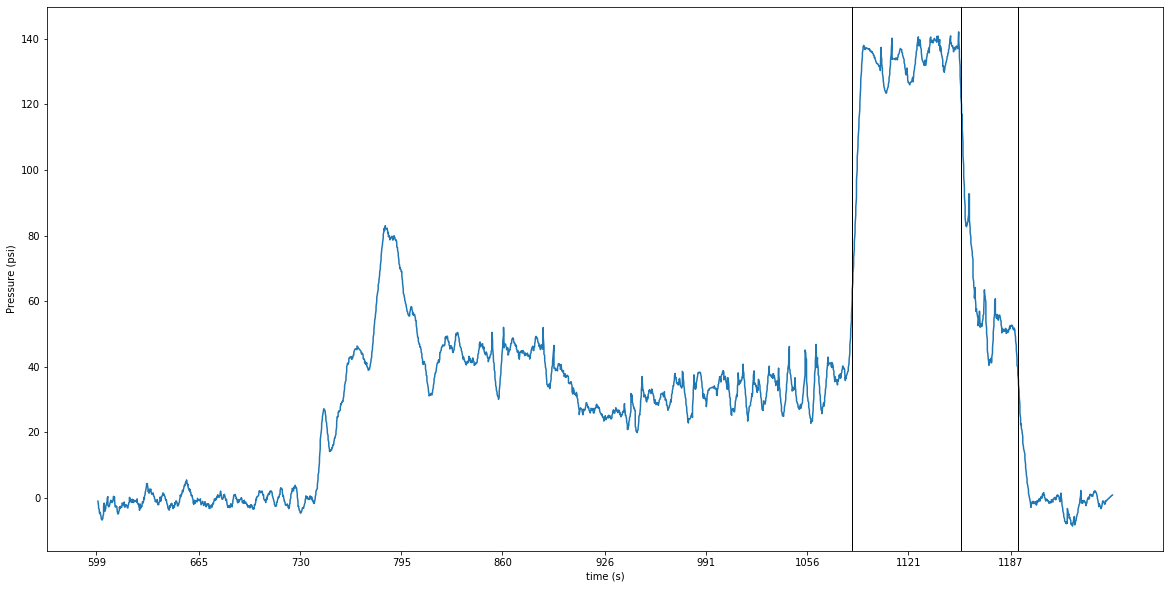

In [94]:
processed_tank_data = edit_lines(processed_tank_data)

Once data manipulation is complete, running the function "values" with the most recent data as the input returns different values depending on what data type is being passed in (to be specified through user input).  In this case, since the data is propane tank data, the function returns 5 values: static pressure (sp), dynamic pressure (dp), droop, emptying time (et), and dynamic rate of increase (ROI), respectively.  

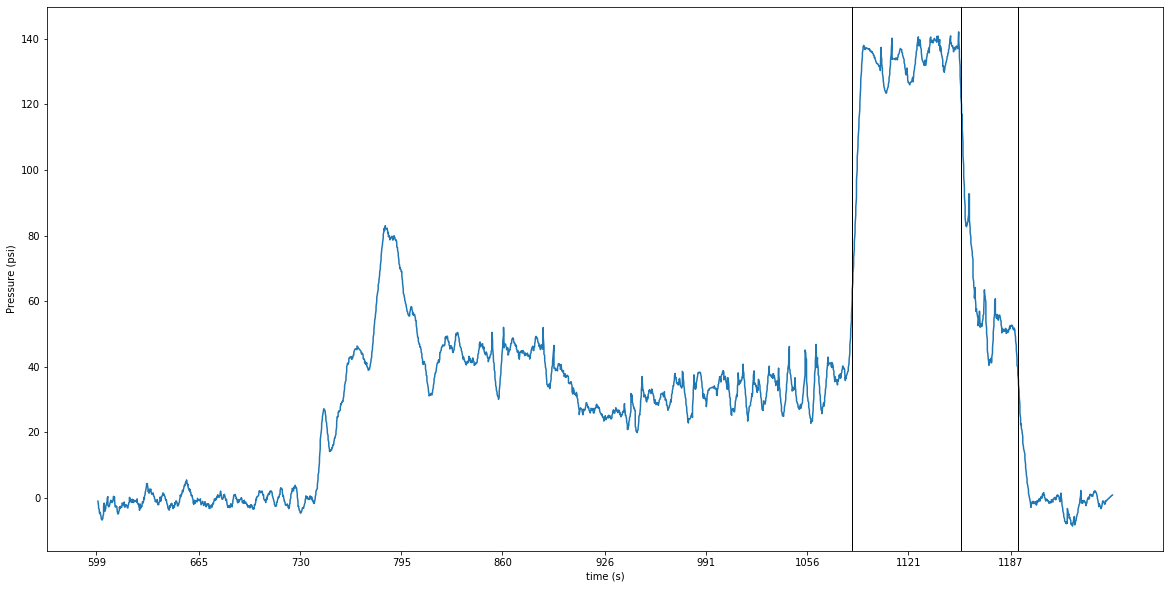

KeyboardInterrupt: 

In [96]:
tank_sp, tank_dp, tank_droop, tank_et, tank_dROI = values(processed_tank_data)
plt.plot(time[start_index:end_index], smoothed_lox_injector[start_index:end_index])

LOX TANK

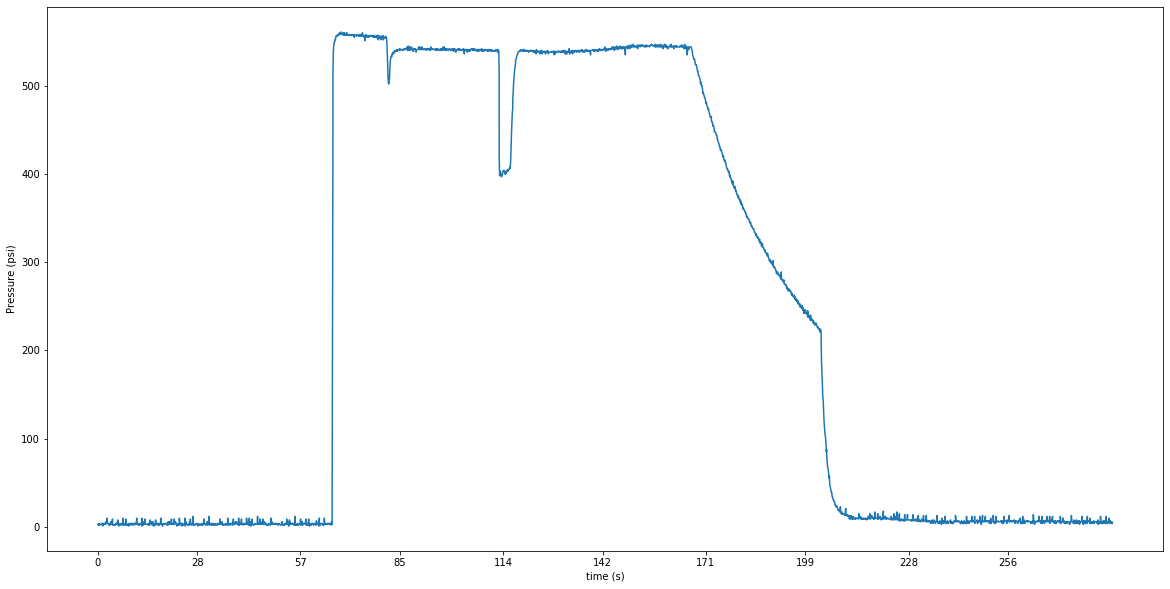

In [163]:
display_pressure(time, lox_tank, [])

In [164]:
start_time = 60
end_time = 200

start_index = min(range(len(time)), key=lambda i: abs(time[i]-start_time))
end_index = min(range(len(time)), key=lambda i: abs(time[i]-end_time)) if end_time != -1 else -1
    

processed_tank_data_2 = np.array([time[start_index:end_index], lox_tank[start_index:end_index]])

Amount of Data Points: 1392
trying it out: [ 63 564]
Positive Peaks: 2
Negative Peaks: 2
Total Peaks detected: 4
[array([63]), array([564]), array([527]), array([1112])]


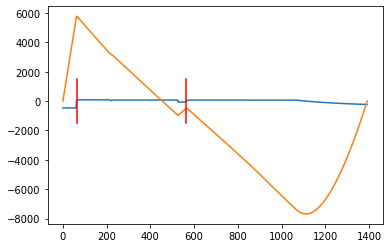

Negative Peaks Detected: 2 at [ 463 1004]
Positive Peaks Detected: 2 at [169 517]
[array([63]), array([564]), array([527]), array([1112]), array([527]), array([1068]), array([233]), array([581])]
[ 463 1004]
testing peaks: [ 63 564]
testing peaks30: [ 464 1013]
testing peaks: [ 63 564]
testing peaks30: [ 464 1013]
This is peaksall: [array([63]), array([564]), array([527]), array([1112]), array([527]), array([1068]), array([233]), array([581]), array([528]), array([1077]), array([244]), array([593])]


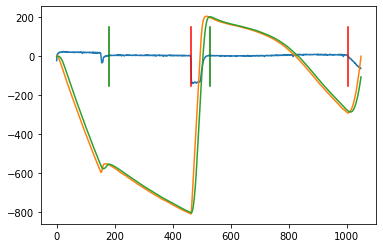

end of second round
Negative Peaks Detected: 1 at [154]
Positive Peaks Detected: 1 at [5]
[array([63]), array([233]), array([244]), array([527]), array([527]), array([528]), array([564]), array([581]), array([593]), array([1068]), array([1077]), array([1112]), array([218]), array([69])]
[154]


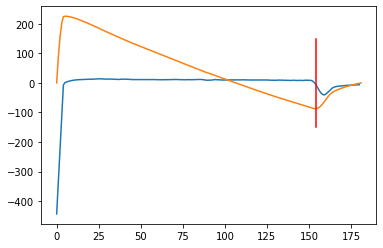

end of third round


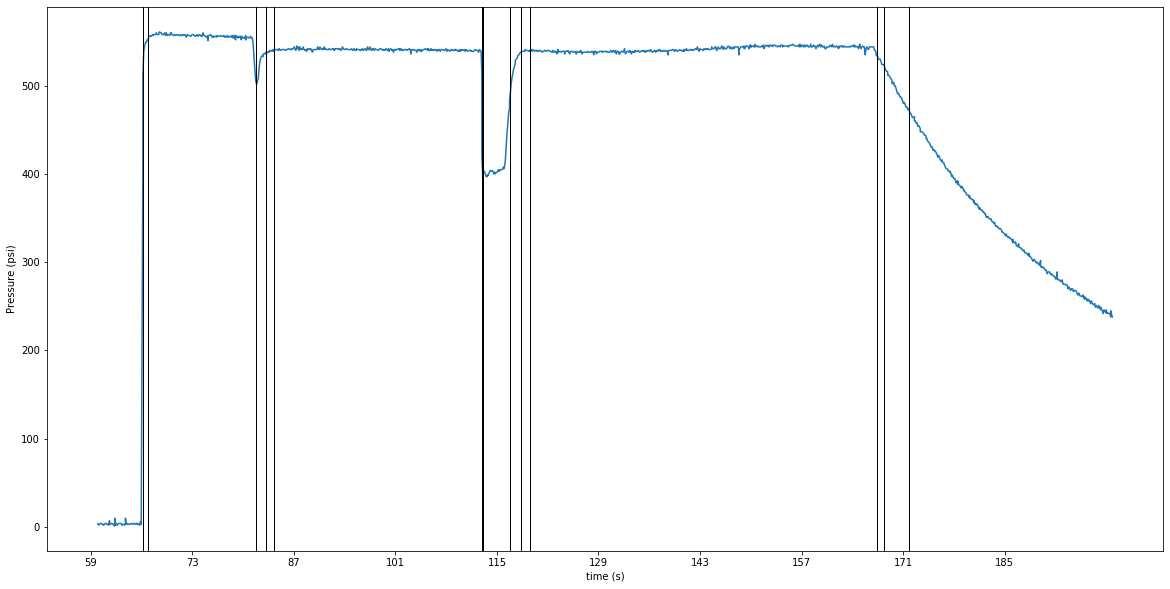

In [165]:
processed_tank_data_2 = detect_peaks(processed_tank_data_2)

In [ ]:
processed_tank_data_2 = [processed_tank_data_2[0][1700:2500], processed_tank_data_2[1][1700:2500]]
display_pressure(processed_tank_data_2[0], processed_tank_data_2[1], [])

In [ ]:
processed_tank_data_2 = remove_lines(processed_tank_data_2)

In [ ]:
processed_tank_data_2 = add_lines(processed_tank_data_2)

In [ ]:
processed_tank_data_2 = edit_lines(processed_tank_data_2)

In [ ]:
tank_sp, tank_dp, tank_droop, tank_et, tank_dROI = values(processed_tank_data_2)